## Import Modules

In [1]:
##################
# IMPORT MODULES #
##################

from codecs import ignore_errors # "Implements the 'ignore' error handling, which ignores malformed data and continues"
from mimetypes import init # "Converts between a filename or URL and the MIME (media) type associated with the filename extension"
                           # "Initialize the internal data structures. If given, files must be a sequence of file names which should be used to augment the default type map"
                           # "MIME mappings specify how a statis file should be interpreted by mapping file extensions to MIME types"
from re import sub # "Reuglar expression matching operations" 
                   # "Return the string obtained by replacing the leftmost non-overlapping occurrences of pattern in string by rhe replacement repl"
import os.path # Work with pathnames to files
import json # JSON encoder & decoder
from functools import partial # "Functions that act on or return other functions - any callable object can be treated as a function"
                              # "Return a new partial object which when called will behave like func called with the positional arguments args and keyword arguements keywords"

from gerrychain import (GeographicPartition, Partition, Graph, MarkovChain,
                        proposals, updaters, constraints, accept, Election)
from gerrychain.updaters import Tally, cut_edges
from gerrychain.proposals import recom

import pandas as pd
import numpy as np
import time

# Additional modules for importing shapefile stuff
import geopandas as gpd # "Extends the datatypes used by pandas to allow spatial operations on geometric types. Geometric operations are performed by shapley"
from scipy.stats import beta


### Testing modules 

In [2]:
import matplotlib.pyplot as plt

## File Pathing
These are for my own computer right now - would have to change to play with it

In [3]:
##################
# RELEVANT FILES #
##################

# Path to the source file of your vtds
# If using a shapefile, point to .shp. All connected shapefiles you want to use must be in same directory
input_file ="/Users/rebeccawagner/Desktop/Alabama_VTD_District_Intersection.shp"


# Path to your output for the vtd district assignments
output_csv = "/Users/rebeccawagner/Desktop/csv"

# Path to the metadata output file
output_metadata = "/Users/rebeccawagner/Desktop/metadata"


## Create Graph

In [4]:
#########################
# MAKE THE GRAPH OBJECT #
#########################

# I first convert to geodataframe in case anything needs to be cleaned up.
# Originally there were some columns I needed to get rid of and others I needed to clean up, but this may no longer be the case

al_gdf = gpd.read_file(input_file) # returns a GeoDataFrame from file
al_gdf["incumbent"] = al_gdf["incumbent"].fillna(0) # Clean up data. Make sure that if there are no incumbents, it's 0. 

graph_AL = Graph.from_geodataframe(al_gdf, ignore_errors=True) # Saving info from .json file as graph object
                                                               # The areas of the polygons are included as node attributes (key area). Shared perimeter of neighboring polygons 
                                                                   # are included as edge attributes (key shared_perim)
                                                               # key boundry_node = T/F & key boundary_perim on boundry polygons
                                                               # Is a geodataframe a .geojson? Need more clarity on file types. Pointing to the .shp gets the associated files?
                                                               # Why are we ignoring errors? What makes an invalid geometry
                                                                   # "Ignore all invalid geometries and attempt to create the graph anyway"
                                            
graph = graph_AL

/Users/rebeccawagner/.local/lib/python3.8/site-packages/gerrychain/graph/adjacency.py:21: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  geometries[i].id = i
/Users/rebeccawagner/.local/lib/python3.8/site-packages/gerrychain/graph/adjacency.py:23: ShapelyDeprecationWarning: STRtree will be changed in 2.0.0 and will not be compatible with versions < 2.
  tree = STRtree(geometries)
/Users/rebeccawagner/.local/lib/python3.8/site-packages/gerrychain/graph/graph.py:169: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  areas = df.geometry.area.to_dict()
/Users/rebeccawagner/.local/lib/python3.8/site-packages/gerrychain/graph/graph.py:296: UserWarning: NA values found in column last!
  warnings.warn("NA values found in column {}!".format(column))
/Users/rebeccawagner/.loc

In [5]:
al_gdf.head()

,OBJECTID,Join_Count,TARGET_FID,cd_117,VTD,vtd_cd_117,dups,total,one_race,wht_1,...,last,first,middle,race,res_ad_lat,res_ad_lon,incumbent,Shape_Le_1,Shape_Area,geometry
0,1,0,0,01001,01003000001,01003000001_01001,0,357,334,256,...,None,None,None,None,0.0,0.0,0,1.004504,0.024391,"POLYGON ((-87.76515 31.29735, -87.76360 31.297..."
1,2,0,1,01001,01003000002,01003000002_01001,0,251,242,98,...,None,None,None,None,0.0,0.0,0,1.012120,0.022135,"POLYGON ((-87.81299 31.13709, -87.81653 31.131..."
2,3,0,2,01001,01003000003,01003000003_01001,0,558,538,260,...,None,None,None,None,0.0,0.0,0,0.597227,0.010159,"POLYGON ((-87.90042 30.93770, -87.90144 30.937..."
3,4,0,3,01001,01003000004,01003000004_01001,0,1175,1119,821,...,None,None,None,None,0.0,0.0,0,0.641053,0.012414,"POLYGON ((-87.92361 30.93146, -87.92348 30.931..."
4,5,0,4,01001,01003000005,01003000005_01001,0,1632,1578,401,...,None,None,None,None,0.0,0.0,0,0.188839,0.000877,"POLYGON ((-87.77521 30.83709, -87.77556 30.837..."


In [6]:
al_gdf.info() # Would like to know what all of these are 

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1844 entries, 0 to 1843
Data columns (total 29 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    1844 non-null   int64   
 1   Join_Count  1844 non-null   int64   
 2   TARGET_FID  1844 non-null   int64   
 3   cd_117      1844 non-null   object  
 4   VTD         1844 non-null   object  
 5   vtd_cd_117  1844 non-null   object  
 6   dups        1844 non-null   int64   
 7   total       1844 non-null   int64   
 8   one_race    1844 non-null   int64   
 9   wht_1       1844 non-null   int64   
 10  blk_1       1844 non-null   int64   
 11  na_1        1844 non-null   int64   
 12  asn_1       1844 non-null   int64   
 13  haw_1       1844 non-null   int64   
 14  oth_1       1844 non-null   int64   
 15  multi       1844 non-null   int64   
 16  blk_combo   1844 non-null   int64   
 17  Shape_Leng  1844 non-null   float64 
 18  county      1844 non-null   object  
 19

### Incumbents?

In [7]:
idx = al_gdf["incumbent"] != 0
al_gdf[idx]

,OBJECTID,Join_Count,TARGET_FID,cd_117,VTD,vtd_cd_117,dups,total,one_race,wht_1,...,last,first,middle,race,res_ad_lat,res_ad_lon,incumbent,Shape_Le_1,Shape_Area,geometry
132,133,1,132,01001,01097000058,01097000058_01001,0,2517,2378,2084,...,carl,jerry,l,w,30.634001,-88.334801,1,0.441253,0.004774,"POLYGON ((-88.29591 30.64218, -88.29587 30.642..."
277,278,1,277,01002,01031000000,01031000000_01002,0,6,3,0,...,moore,barry,None,w,31.421101,-85.791603,1,0.439101,0.005779,"POLYGON ((-85.78931 31.49093, -85.78932 31.490..."
565,566,1,565,01003,01015000019,01015000019_01003,0,8980,8410,6125,...,rogers,mike,None,w,33.740501,-85.849998,1,0.344603,0.002929,"POLYGON ((-85.85414 33.75409, -85.85406 33.754..."
1133,1134,1,1133,01004,01133000002,01133000002_01004,0,7603,7126,6680,...,aderholt,robert,None,w,34.227901,-87.622398,1,0.728652,0.016189,"POLYGON ((-87.57328 34.30534, -87.56502 34.305..."
1459,1460,1,1459,01006,01117000018,01117000018_01006,0,7626,7194,6640,...,palmer,gary,None,w,33.407501,-86.745499,1,0.260523,0.001459,"POLYGON ((-86.73955 33.41680, -86.73958 33.416..."
1675,1676,1,1675,01007,01073003210,01073003210_01007,1,2128,2015,986,...,sewell,terri,a,b,33.347900,-86.882500,1,0.088335,0.000216,"POLYGON ((-86.87576 33.35386, -86.87628 33.352..."


### Graphing 

In [8]:
graph_AL.edges, graph_AL.nodes

(EdgeView([(0, 72), (0, 10), (0, 1516), (0, 164), (0, 1), (1, 2), (1, 11), (1, 10), (1, 1516), (1, 78), (1, 79), (1, 202), (2, 14), (2, 3), (2, 84), (2, 11), (2, 78), (3, 16), (3, 4), (3, 14), (3, 5), (3, 92), (3, 87), (3, 84), (4, 15), (4, 16), (4, 14), (5, 34), (5, 122), (5, 44), (5, 101), (5, 6), (5, 17), (5, 16), (5, 95), (5, 92), (6, 45), (6, 44), (6, 7), (6, 19), (6, 8), (6, 17), (7, 22), (7, 19), (7, 8), (8, 23), (8, 24), (8, 22), (8, 17), (8, 21), (9, 162), (9, 43), (9, 48), (9, 41), (10, 71), (10, 72), (10, 13), (10, 12), (10, 11), (11, 14), (11, 12), (12, 14), (12, 13), (13, 14), (13, 75), (14, 15), (14, 18), (15, 17), (15, 16), (15, 18), (16, 17), (17, 21), (17, 18), (18, 21), (18, 20), (19, 41), (19, 34), (19, 45), (19, 22), (20, 26), (20, 25), (20, 21), (21, 24), (21, 25), (22, 42), (22, 23), (22, 48), (22, 41), (23, 30), (23, 29), (23, 24), (24, 30), (24, 25), (25, 30), (25, 27), (25, 26), (26, 27), (27, 30), (27, 28), (27, 31), (28, 33), (28, 31), (29, 30), (29, 42), (29

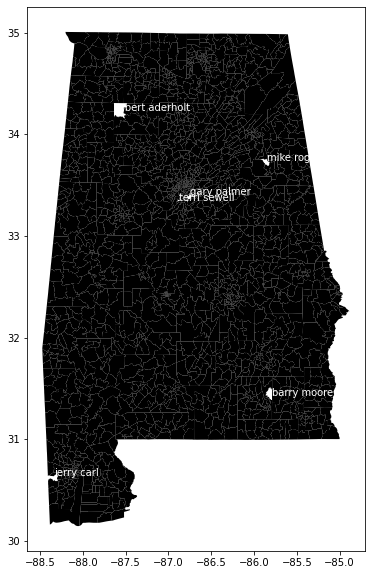

In [9]:
# Question: When districts are redrawn, need to determine if multiple incumbents are in the same district.
#   Will need to inspect some output! (Looks like this is handled by one of the "updaters"

al_gdf.plot(figsize=(10,10), column='incumbent', cmap='gray')
ax = plt.gca()

for incumb in al_gdf[idx].to_dict(orient='records'):
    plt.text(incumb['res_ad_lon'], incumb['res_ad_lat'], 
             incumb['first'] + ' ' + incumb['last'], 
             color='w')

plt.show()

## Updaters

In [10]:
############
# UPDATERS #
############

# These are manually defined updaters. Some will be used as constraints, others are just to record information.


# I made three different updates to track county splitting
# All three pull information from the built-in updater.county_splits function, which I labeled "county_info" for a little more readability

# "split_counter" records the number of splits that occur. 
# If a county is split into two districts, that's one split, if a county is split into three districts, that's two splits
def split_counter(partition):
    count_splits = 0
    for item in partition["county_info"]:
        count_splits += len(partition["county_info"][item][2]) - 1
    return count_splits


# "num_split_counties" records the number of counties that have been split at least once. 
# If a county is split into two districts, that's one split county, if a county is split into three districts, that's still one split county
def num_split_counties(partition):
    counties_with_splits = 0
    for item in partition["county_info"]:
        if len(partition["county_info"][item][2]) > 1:
            counties_with_splits += 1
    return counties_with_splits

# "oversplit_counties" tracks the number of counties that have been split more than once, as some states don't allow plans that do that.
# If a county is split into two districts, that's zero oversplit counties, if a county is split into three or more districts, that's one oversplit county
def oversplit_counties(partition):
    oversplits = 0
    for item in partition["county_info"]:
        if len(partition["county_info"][item][2]) > 2:
            oversplits += 1
    return oversplits


# bad_incumbents tracks the number of districts in a plan with two or greater incumbents by tallying up the number of incumbents in all the VTDs for each district
def bad_incumbents(partition):
    num_problems = 0
    for part in partition.parts:
        if partition["incumbents"][part] > 1:
            num_problems += 1
    return num_problems

# subpop_over_threshold tracks the number of districts above a threshold value for a defined subpopulation. 
def subpop_over_threshold(partition):
    count_over = 0
    alpha = 0.5# Arbitrarily defined threshold
    for dist in partition['population']:
        # whatever this first term is needs to be an updater in my updaters so the constraint validator can look for it
        if partition['subpop'][dist] / partition['population'][dist] >= alpha:
            count_over += 1
    return count_over



# Selecting/defining updaters that gerrychain should calculate and keep track of over each iteration
# Gerry chain keeps track of several automatically (area, perimeter, cut_edges, etc.)

my_updaters = {
    "population": updaters.Tally("total", alias="population"), # Population updater, for computing how close to equality the district populations are
    "county_info": updaters.county_splits("county_info", "county"),# built in function to generate county info.
    "split_counter": split_counter,# pulls from county_info to get total number of county splits.
    "num_split_counties": num_split_counties,
    "oversplit_counties": oversplit_counties,
    "incumbents": updaters.Tally("incumbent", alias="incumbents"),
    "bad_incumbents": bad_incumbents,
    "subpop": updaters.Tally("blk_1", alias="subpop"),
    "subpop_dists": subpop_over_threshold,
    }


## Constraints & Chain Details

In [11]:
#################################
# CONSTRAINTS AND CHAIN DETAILS #
#################################


###########################################################################
# This defines the initial partition that gets fed into the Markov Chain. #
###########################################################################

# graph is the object it pulls info from, assignment= is the grouping variable for the starting district plan, and updaters= are your updaters (see above)

initial_partition = GeographicPartition(graph, assignment="cd_117", updaters=my_updaters) # GeographicPartitian comes with built-in area and perimeter updaters for compactness.
                                                                                          # I'm guessing that cd_117 means the district map from the 117th congress (01/2021-01/2023).
                                                                                               # So the initial partitian is just the original map according to 117th congress. 
                                                                                               # al_gdf["cd_117"] assigns nodes to districts as a dictionary. See below. 


### 117th Congress District Map

In [12]:
al_gdf["cd_117"].unique() # I think that these numbers reference each district in Alabama (There are 7). So the column name references 117th congress map and the entry value indicates 
                          # which AL district the VTD(?) is in.

array(['01001', '01002', '01003', '01004', '01005', '01006', '01007'],
      dtype=object)

### Initial Partition

In [13]:
initial_partition.graph # Frozen = Immutable graph. has .edges and .nodes 
                        # initial_partition["area"], initial_partition["perimeter"], initial_partition["population"] all work 
                        # Not sure if there are any others, I found those by trial and error. Can't find it in documentation...

In [14]:
# These structures are based on NetworkX graphs
initial_partition.graph.nodes[0] # See the data a node contains

{'boundary_node': False,
 'area': 0.0243912102049998,
 'OBJECTID': 1,
 'Join_Count': 0,
 'TARGET_FID': 0,
 'cd_117': '01001',
 'VTD': '01003000001',
 'vtd_cd_117': '01003000001_01001',
 'dups': 0,
 'total': 357,
 'one_race': 334,
 'wht_1': 256,
 'blk_1': 59,
 'na_1': 18,
 'asn_1': 0,
 'haw_1': 0,
 'oth_1': 1,
 'multi': 23,
 'blk_combo': 62,
 'Shape_Leng': 1.00450358645,
 'county': '01003',
 'last': None,
 'first': None,
 'middle': None,
 'race': None,
 'res_ad_lat': 0.0,
 'res_ad_lon': 0.0,
 'incumbent': 0,
 'Shape_Le_1': 1.004503586450656,
 'Shape_Area': 0.024391210205,
 'geometry': <shapely.geometry.polygon.Polygon at 0x7f7ba60760a0>}

In [15]:
initial_partition.graph[1843] # Pretty sure the number here coresponds to the ID in the original al_gdf dataframe. Try 1844 and get key error bc there are only 
                              # 1844 entries (numbered 0 to 1843). Looks like the partition returns all the nodes it's connected to and their shared perimeter

AtlasView({1533: {'shared_perim': 0.0594791134977036}, 1709: {'shared_perim': 0.02068554674402099}, 1835: {'shared_perim': 0.01633388307927864}, 1841: {'shared_perim': 0.09667016163697094}, 1842: {'shared_perim': 0.05723766624156481}})

### Setting Chain Details

In [16]:
# The ReCom proposal needs to know the ideal population for the districts so that
# we can improve speed by bailing early on unbalanced partitions.
ideal_population = sum(initial_partition["population"].values()) / len(initial_partition)


# We use functools.partial to bind the extra parameters (pop_col, pop_target, epsilon, node_repeats)
# of the recom proposal.
pop_deviation = 0.005

# This is the syntax for the Recom algorithm. I don't know what node_repeats means, default was 10 so I kept it there.
proposal = partial(recom,
                   pop_col="total",
                   pop_target=ideal_population,
                   epsilon=pop_deviation,
                   node_repeats=10
                  )

# I manually define constraints below.

# Keep populations with percent of ideal
pop_constraint = constraints.within_percent_of_ideal_population(initial_partition, pop_deviation)


# Prebuilt contiguity constraint
contiguity = constraints.contiguous


# # Prebuilt constraint that refuses partitions that created new county splits.
# county_limit = constraints.refuse_new_splits("county_info")

# Homebrewed alternative to "refuse_new_splits" that lets you define how many splits are allowed
county_limit = constraints.UpperBound(
    lambda p: split_counter(p),
    3*split_counter(initial_partition)
)


# Setting parameters for chain. Proposal (recom vs flip vs other), constraints, any additional acceptance criteria, initial state, and total number of iterations
chain = MarkovChain(
    proposal=proposal,
    constraints=[
        pop_constraint,
        contiguity,
        county_limit,
    ],
    accept=accept.always_accept,
    initial_state=initial_partition,
    total_steps=30 # IMPORTANT - this is the number of iterations you run. The first will be the initial plan. and then it will produce n-1 new plans for a total of n plans
)


## Running the Chain!

In [17]:

##################################
# RUNNNING CHAIN AND SAVING DATA #
##################################

# Initializing variables
count = 0# recording iteration count
chain_list = []# blank list to vtd assignment for each iteration
metadata_list = []# blank list to store metadata
tot_num_edges = graph.number_of_edges() #will be used to calculate proportion of edges not cut
start_time = time.time()

# The Chain itself
for partition in chain:
    count += 1
    # bad_incumbents = 0
    part_dict = {"Iteration": count}
    meta_dict = {"Iteration": count}
    print("Iteration " + str(count)) # uncomment line if you want to watch the progress

    # Storing all the metadata. I tried to find a better way to code this, but I ended up just hardcoding it in.
    # Dictionary key will be the column name in your metadata output, so you can make it however readable you want it to be
    meta_dict["incumbent_issues"] = partition.bad_incumbents
    meta_dict["prop_uncut_edges"] = 1 - len(partition["cut_edges"])/tot_num_edges
    meta_dict["county_splits"] = partition.split_counter
    meta_dict["num_split_counties"] = partition.num_split_counties
    meta_dict["oversplit_counties"] = partition.oversplit_counties
    meta_dict["black_majority"] = partition.subpop_dists


    # Extracting and storing assingment for each VTD
    for nodenum in range(len(partition.graph.nodes)):
        part_dict[str(partition.graph.nodes[nodenum]['vtd_cd_117'])] = partition.assignment[nodenum]
    chain_list.append(part_dict)
    metadata_list.append(meta_dict)


end_time = time.time()

print("\nChain complete. Time elapsed: " + str(end_time-start_time) + " seconds.")

##################################
# OUTPUT ASSIGNMENT AND METADATA #
##################################

# turning list of dictionaries indo pandas dataframe object for easy manipulation
chain_df = pd.DataFrame(chain_list)

# Transposing and saving dataframe as csv. 
with open(output_csv, 'w', encoding='utf8', newline='') as output_file:
    transposed_csv = chain_df.T
    transposed_csv.to_csv(output_file, sep=',', encoding='utf-8', header=False)

meta_df = pd.DataFrame(metadata_list)

# Transposing and saving dataframe as csv
with open(output_metadata, 'w', encoding='utf8', newline='') as output_file:
    transposed_csv = meta_df.T
    transposed_csv.to_csv(output_file, sep=',', encoding='utf-8', header=False)

print("Success!")

Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30

Chain complete. Time elapsed: 28.174603939056396 seconds.
Success!


## Chain Output

In [18]:
chain_df # This df is made from a dictionary of VTDs to district assignments for each iteration
         # Column names are VTD IDs, data is the assigned district. 

,Iteration,01003000001_01001,01003000002_01001,01003000003_01001,01003000004_01001,01003000005_01001,01003000006_01001,01003000007_01001,01003000008_01001,01003000009_01001,...,01131005001_01007,01131005002_01007,01131005003_01007,01131005004_01007,01131005005_01007,01131005006_01007,01131006001_01007,01131006002_01007,01131006004_01007,01131006005_01007
0,1,01001,01001,01001,01001,01001,01001,01001,01001,01001,...,01007,01007,01007,01007,01007,01007,01007,01007,01007,01007
1,2,01007,01007,01007,01007,01007,01007,01007,01007,01007,...,01001,01001,01001,01001,01001,01001,01001,01001,01001,01001
2,3,01007,01007,01007,01007,01007,01007,01007,01007,01007,...,01001,01001,01001,01001,01001,01001,01001,01001,01001,01001
3,4,01007,01007,01007,01007,01007,01007,01007,01007,01007,...,01001,01001,01001,01001,01001,01001,01001,01001,01001,01001
4,5,01002,01002,01002,01002,01002,01002,01002,01002,01002,...,01001,01001,01001,01001,01001,01001,01001,01001,01001,01001
5,6,01002,01002,01002,01002,01002,01002,01002,01002,01002,...,01003,01003,01003,01003,01003,01003,01003,01003,01003,01003
6,7,01002,01002,01002,01002,01002,01002,01002,01002,01002,...,01003,01003,01003,01003,01003,01003,01003,01003,01003,01003
7,8,01002,01002,01002,01002,01002,01002,01002,01002,01002,...,01003,01003,01003,01003,01003,01003,01003,01003,01003,01003
8,9,01002,01002,01002,01002,01002,01002,01002,01002,01002,...,01003,01003,01003,01003,01003,01003,01003,01003,01003,01003
9,10,01002,01002,01002,01002,01002,01002,01002,01002,01002,...,01003,01003,01003,01003,01003,01003,01003,01003,01003,01003


In [19]:
def clean_chain_output(chain_df):
    '''cleans up the original chain_df from gerry chain code for manipulation
    returns cleaned data as a geoDataFrame'''
    
    chain_df = chain_df.transpose() 
    chain_df.reset_index(inplace=True)
    chain_df = chain_df.rename(columns = {"index":"vtd_cd_117"})
    chain_df =chain_df.drop(labels=0)
    chain_df = gpd.GeoDataFrame(chain_df)
    
    return chain_df
    

In [20]:
clean_chain_df = clean_chain_output(chain_df)
clean_chain_df

,vtd_cd_117,0,1,2,3,4,5,6,7,8,...,20,21,22,23,24,25,26,27,28,29
1,01003000001_01001,01001,01007,01007,01007,01002,01002,01002,01002,01002,...,01007,01007,01007,01007,01007,01007,01007,01007,01007,01007
2,01003000002_01001,01001,01007,01007,01007,01002,01002,01002,01002,01002,...,01007,01007,01007,01007,01007,01007,01007,01007,01007,01007
3,01003000003_01001,01001,01007,01007,01007,01002,01002,01002,01002,01002,...,01007,01007,01007,01007,01007,01007,01007,01007,01007,01007
4,01003000004_01001,01001,01007,01007,01007,01002,01002,01002,01002,01002,...,01007,01007,01007,01007,01007,01007,01007,01007,01007,01007
5,01003000005_01001,01001,01007,01007,01007,01002,01002,01002,01002,01002,...,01007,01007,01007,01007,01007,01007,01007,01007,01007,01007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1840,01131005006_01007,01007,01001,01001,01001,01001,01003,01003,01003,01003,...,01003,01003,01006,01006,01006,01003,01003,01003,01003,01001
1841,01131006001_01007,01007,01001,01001,01001,01001,01003,01003,01003,01003,...,01003,01003,01006,01006,01006,01003,01003,01003,01003,01001
1842,01131006002_01007,01007,01001,01001,01001,01001,01003,01003,01003,01003,...,01003,01003,01006,01006,01006,01003,01003,01003,01003,01001
1843,01131006004_01007,01007,01001,01001,01001,01001,01003,01003,01003,01003,...,01003,01003,01006,01006,01006,01003,01003,01003,01003,01001


In [21]:
# Merge with the original geodataframe
merged_gdf = al_gdf.merge(right=clean_chain_df,on="vtd_cd_117")
merged_gdf

,OBJECTID,Join_Count,TARGET_FID,cd_117,VTD,vtd_cd_117,dups,total,one_race,wht_1,...,20,21,22,23,24,25,26,27,28,29
0,1,0,0,01001,01003000001,01003000001_01001,0,357,334,256,...,01007,01007,01007,01007,01007,01007,01007,01007,01007,01007
1,2,0,1,01001,01003000002,01003000002_01001,0,251,242,98,...,01007,01007,01007,01007,01007,01007,01007,01007,01007,01007
2,3,0,2,01001,01003000003,01003000003_01001,0,558,538,260,...,01007,01007,01007,01007,01007,01007,01007,01007,01007,01007
3,4,0,3,01001,01003000004,01003000004_01001,0,1175,1119,821,...,01007,01007,01007,01007,01007,01007,01007,01007,01007,01007
4,5,0,4,01001,01003000005,01003000005_01001,0,1632,1578,401,...,01007,01007,01007,01007,01007,01007,01007,01007,01007,01007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1839,1840,0,1839,01007,01131005006,01131005006_01007,0,508,505,39,...,01003,01003,01006,01006,01006,01003,01003,01003,01003,01001
1840,1841,0,1840,01007,01131006001,01131006001_01007,0,429,420,145,...,01003,01003,01006,01006,01006,01003,01003,01003,01003,01001
1841,1842,0,1841,01007,01131006002,01131006002_01007,0,1242,1217,480,...,01003,01003,01006,01006,01006,01003,01003,01003,01003,01001
1842,1843,0,1842,01007,01131006004,01131006004_01007,0,208,208,16,...,01003,01003,01006,01006,01006,01003,01003,01003,01003,01001


In [22]:
merged_gdf.info() # Columns 1-9 have each iterations assignments. Column 0 is the original map

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 1844 entries, 0 to 1843
Data columns (total 59 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    1844 non-null   int64   
 1   Join_Count  1844 non-null   int64   
 2   TARGET_FID  1844 non-null   int64   
 3   cd_117      1844 non-null   object  
 4   VTD         1844 non-null   object  
 5   vtd_cd_117  1844 non-null   object  
 6   dups        1844 non-null   int64   
 7   total       1844 non-null   int64   
 8   one_race    1844 non-null   int64   
 9   wht_1       1844 non-null   int64   
 10  blk_1       1844 non-null   int64   
 11  na_1        1844 non-null   int64   
 12  asn_1       1844 non-null   int64   
 13  haw_1       1844 non-null   int64   
 14  oth_1       1844 non-null   int64   
 15  multi       1844 non-null   int64   
 16  blk_combo   1844 non-null   int64   
 17  Shape_Leng  1844 non-null   float64 
 18  county      1844 non-null   object  
 19

### Visualize the new maps

You can see the districts changing here. I'm not exactly sure how much they're supposed to change given the algorithm with 
ReCom. 

Does ReCom combine and resplit /districts/ or /VTDs/? Refer back to original paper


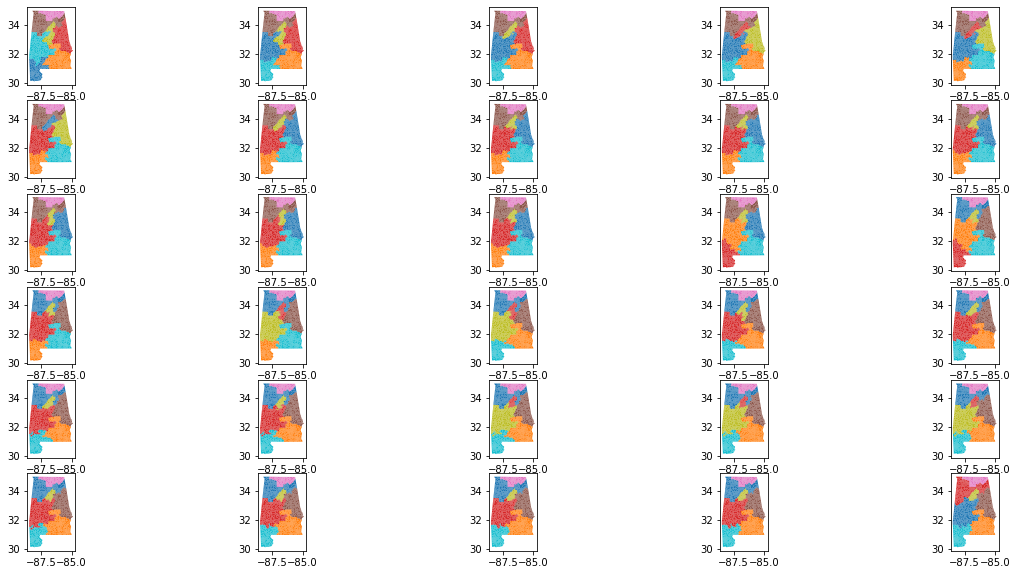

In [23]:
# Iterations from left to right, top to bottom (original at 0,0 and iteration 10 at 1,4)

fig,ax = plt.subplots(6,5,figsize=(20,10)) # A bit of a clunky loop for graphing each iteration. This whole process can
                                           # easily be turned into a function to vizualise every x iterations 

for i in range(0,5):
    cur_ax = ax[0,i]
    merged_gdf.plot(ax=cur_ax, column=i)

for i in range(0,5):
    cur_ax = ax[1,i]
    merged_gdf.plot(ax=cur_ax, column=i+5)

for i in range(0,5):
    cur_ax = ax[2,i]
    merged_gdf.plot(ax=cur_ax, column=i+10)

for i in range(0,5):
    cur_ax = ax[3,i]
    merged_gdf.plot(ax=cur_ax, column=i+15)

for i in range(0,5):
    cur_ax = ax[4,i]
    merged_gdf.plot(ax=cur_ax, column=i+20)
    
for i in range(0,5):
    cur_ax = ax[5,i]
    merged_gdf.plot(ax=cur_ax, column=i+25)

### What Changed?

In [28]:
def what_changed(df, x, y):
    '''shows all the changed VTDs between iterations x and y
    pass in cleaned_chain_df'''
    
    idx = df[x] != df[y]
    return df[idx][['vtd_cd_117',x,y]]

In [29]:
what_changed(clean_chain_df,0,1)

,vtd_cd_117,0,1
1,01003000001_01001,01001,01007
2,01003000002_01001,01001,01007
3,01003000003_01001,01001,01007
4,01003000004_01001,01001,01007
5,01003000005_01001,01001,01007
...,...,...,...
1840,01131005006_01007,01007,01001
1841,01131006001_01007,01007,01001
1842,01131006002_01007,01007,01001
1843,01131006004_01007,01007,01001


In [30]:
what_changed(clean_chain_df,1,2)

,vtd_cd_117,1,2
1318,01007000003_01006,01006,01001
1319,01007000004_01006,01006,01001
1320,01007000005_01006,01006,01001
1321,01007000007_01006,01006,01001
1322,01007000009_01006,01006,01001
...,...,...,...
1807,01125000045_01007,01001,01006
1808,01125000046_01007,01001,01006
1810,01125000048_01007,01001,01006
1811,01125000049_01007,01001,01006


## Meta Output

In [292]:
meta_df # Haven't done much with this but we know we have it

,Iteration,incumbent_issues,prop_uncut_edges,county_splits,num_split_counties,oversplit_counties,black_majority
0,1,0,0.916444,6,6,0,1
1,2,0,0.917970,9,9,0,1
2,3,0,0.913773,13,12,1,1
3,4,0,0.914346,14,12,2,1
4,5,0,0.913392,14,13,1,1
5,6,0,0.913773,13,11,2,1
6,7,0,0.915109,14,12,2,1
7,8,1,0.920832,14,13,1,0
8,9,1,0.920641,16,14,2,0
9,10,1,0.919496,16,14,2,0


In [293]:
meta_dict

{'Iteration': 10,
 'incumbent_issues': 1,
 'prop_uncut_edges': 0.9194963754292255,
 'county_splits': 16,
 'num_split_counties': 14,
 'oversplit_counties': 2,
 'black_majority': 0}